# Predicting Perovskite Volumes

This dataset comes from a perovskite database hosted by the NOMAD lab (https://nomad-lab.eu/). In this notebook, we'll featurize a set of crystal cells automatically using XenonPy, and we'll create a model to predict the volume automatically using TPOT.

Let's start off by installing nomad-lab from pip. We'll also need to install TPOT and XenonPy

In [1]:
!pip install nomad-lab tpot xenonpy

# Import Packages
We'll import some standard Python ML packages.

In addition, we'll import a couple of others:
- XenonPy (https://xenonpy.readthedocs.io/en/latest/index.html) is a materials science toolkit similar to RDKit, generating features for materials inputs
- TPOT (http://epistasislab.github.io/tpot/) is an AutoML tool. Using a genetic algorithm, it acts as a computerized data-scientist, automatically testing and selecting a model for a dataset.
- Nomad API (https://nomad-lab.eu/prod/rae/docs/index.html) allows access to NOMAD's large database of DFT calculations

We'll also specify a random seed, for reproducibility.

In [2]:
import re 

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tpot
import sklearn.pipeline

import ase
import ase.io
import xenonpy.datatools
from xenonpy.descriptor import Compositions
from nomad.client import ArchiveQuery

RANDOM_SEED = 42

/usr/local/anaconda3/lib/python3.8/site-packages/jose/backends/cryptography_backend.py:23: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


# Query NOMAD

We'll first query NOMAD for a database named "stable inorganic perovskites," which has 144 materials inside of it.

Then, we'll convert each feature to an ASE atoms object, for use in featurization down the road.

Finally, we'll save it all to a Pandas dataframe.

In [3]:
# Query NOMAD for a perovskites dataset

search = "stable inorganic perovskites"
query = ArchiveQuery(
    query = {
        "datasets": search
    },
    per_page = 144,
    max = 144
)

# Convert the query to ASE atoms objects
def to_atoms(result):
    """
    Function that takes in a result from NOMAD, and turns it into an ASE atom object.
    The object is based on the standardized unit cell reported by NOMAD.
    
    Args:
        result: The result of a query
    
    Returns:
        The result as an ASE Atoms object
    """
    # Get the description of the standardized unit cell
    system = result.section_run[-1].section_system[-1].section_symmetry[-1].section_std_system[-1]  
    
    # Extract structural parameters
    unit_cell = system.lattice_vectors_std
    fractional_coordinates = system.atom_positions_std
    atomic_symbols = [ase.data.chemical_symbols[atomic_number] for atomic_number in system.atomic_numbers_std]
    
    # Create and return the atoms object
    atoms = ase.Atoms(symbols=atomic_symbols, scaled_positions=fractional_coordinates, cell=unit_cell, pbc=[True, True, True])
    return atoms
    
atoms = [to_atoms(result) for result in query]

raw_data = {
    "Formula": [],
    "Atoms_Object": [],
    "Volume": []
}
for crystal in atoms:
    raw_data["Formula"].append(crystal.get_chemical_formula())
    raw_data["Atoms_Object"].append(crystal)
    raw_data["Volume"].append(crystal.cell.volume)
raw_data = pd.DataFrame.from_dict(raw_data)

# Normalize volume to empirical formula unit. Divide by the number of atoms and multiply by 5 (because these are all ABO3)
raw_data.Volume = 5 * raw_data.Volume / raw_data.Atoms_Object.apply(lambda atoms: len(atoms))
raw_data.head()

/usr/local/anaconda3/lib/python3.8/site-packages/ase/cell.py:97: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  cell = np.array(cell, float)


,Formula,Atoms_Object,Volume
0,AgCl3K,"(Atom('K', [2.546784180928994, 2.5467841809289...",132.452162
1,La2N6W2,"(Atom('La', [2.665318694121161, 2.857224133724...",65.894295
2,O3SrV,"(Atom('Sr', [1.9322684339857643, 1.93226843398...",57.715487
3,Cl6Cs2Tl2,"(Atom('Cs', [7.926562986915786, 0.0, 0.0289390...",176.625755
4,F3MnRb,"(Atom('Rb', [2.1409860345006186, 2.14098603450...",78.511177


# Feature Engineering

Next, we'll featurize our dataset using XenonPy. In a real-world scenario, this is where we should be spending much of our time. Good features lead to good models.

In this case, we're going to just use XenonPy to generate 290 features per entry. In a nutshell, it takes in the composition of each formula unit, and then looks up many descriptors (such as ionization energies).
Then, it derives various properties, such as the minimum, maximum, average, etc. For example, the average 

In [4]:
# Featurize with XenonPy
# Xenonpy needs to download datasets for its featurizers to work
xenonpy.datatools.preset.sync("elements_completed")
element_cal = Compositions()

def featurize(atoms: ase.Atoms):
    # Get the chemical formula as a dict
    symbols = atoms.get_chemical_symbols()
    counts = {symbol: symbols.count(symbol) for symbol in symbols}
    
    # Do the featurization
    result = element_cal.transform([counts])
    return result

new_results = pd.DataFrame()
for index, atoms in zip(raw_data.index, raw_data.Atoms_Object):
    results = featurize(atoms)
    results.index = [index]
    new_results = new_results.append(results)

data = raw_data[["Volume"]].join(new_results)
data.to_csv("perovskite_data.csv")
data.head()

fetching dataset `elements_completed` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements_completed.pd.xz.


,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,132.452162,23.4,164.212290,215.4,22.340,50.663300,849.560,21.280000,908.46,130.8,...,1.0,3.0,0.237,0.00890,175.0,182.0,207.0,314.8,206.0,2.180
1,65.894295,30.4,120.800000,214.8,16.786,72.953294,1978.440,102.018930,912.82,116.4,...,2.0,2.0,0.133,0.02583,155.0,166.0,193.0,309.6,333.6,1.100
2,57.715487,17.0,157.520852,208.8,16.810,37.311700,1115.514,92.159719,847.02,109.2,...,2.0,2.0,0.301,0.02658,152.0,150.0,182.0,314.4,317.5,0.802
3,176.625755,37.4,176.012290,221.8,28.660,88.727090,679.480,9.580000,1492.06,139.0,...,1.0,3.0,0.128,0.00890,175.0,182.0,207.0,394.7,206.0,2.180
4,78.511177,17.8,157.014169,194.2,22.918,39.480211,690.206,52.579364,1065.12,108.2,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,296.1,1300.0,0.557


# Correlation Chart

Below we find a correlation chart, giving a high-level overview of some of the correlations found in the ata. Because there are so many features, it's difficult to determine the individual correlations. That said, what we can see is that we're in a highly-correlated feature space - this can easily be observed by noting the relatively large area consisting of bright yellow and dark blue colors in the plot.

<ipython-input-5-6ffd1ab39c76>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(data.columns, fontsize=1)
<ipython-input-5-6ffd1ab39c76>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(data.columns, fontsize=1)


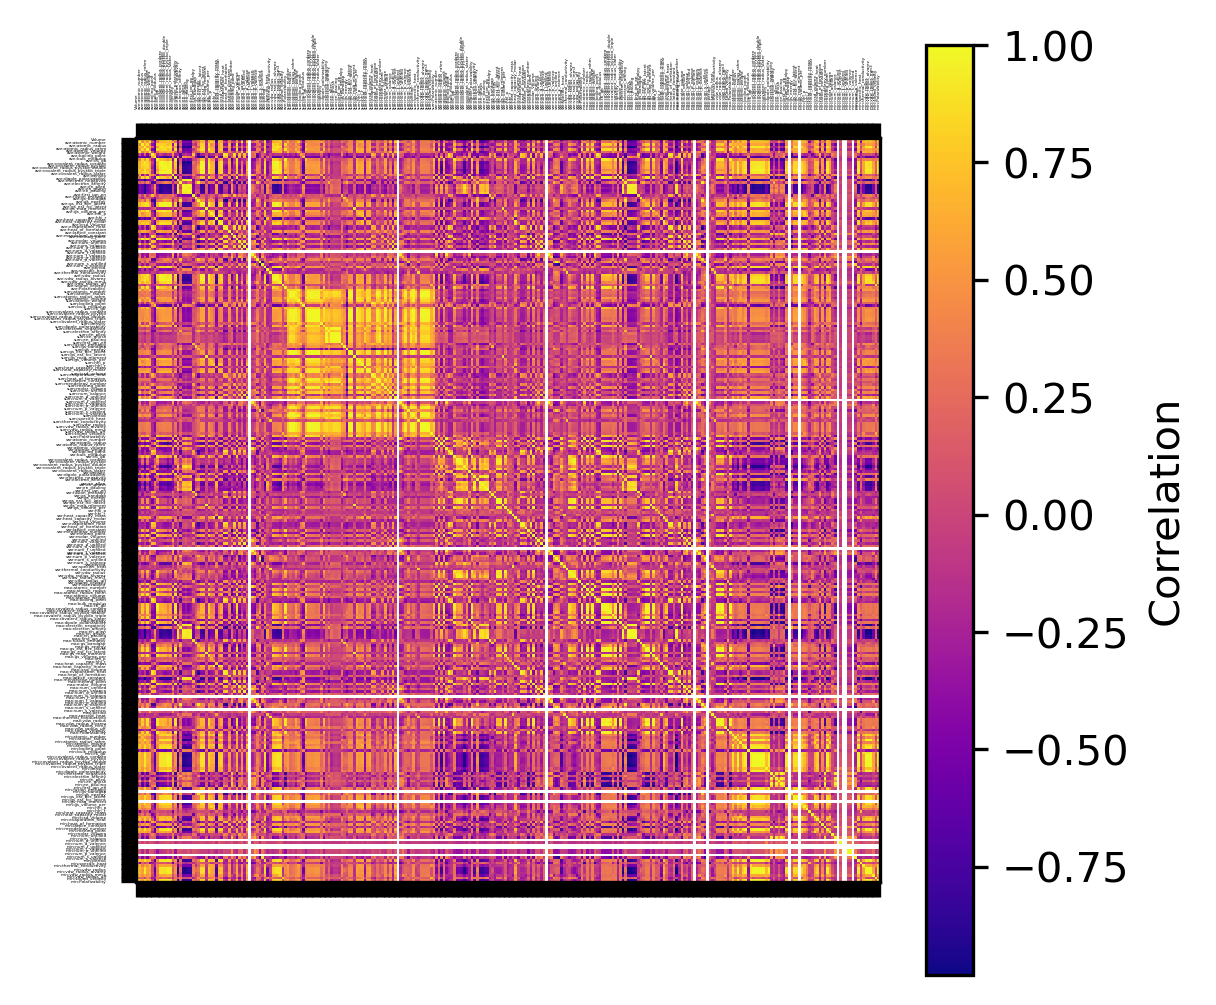

In [5]:
# Let's plot the correlations
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['axes.grid'] = False
cax = plt.matshow(data.corr(), cmap="plasma")
plt.gca().set_xticklabels(data.columns, fontsize=1)
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.gca().set_yticklabels(data.columns, fontsize=1)
plt.xticks(range(len(data.columns)))
plt.yticks(range(len(data.columns)))
plt.colorbar(label="Correlation")
plt.show()

# Train/Test Split

Next, we'll do a train/test split of the dataset. We don't have a lot of data, but we'll try a 50/50 train/test split. We're using a lot of features together with a highly flexible model (TPOT can choose between many different models and many different hyperparameters), so we want it to be very apparent if we're at all overfitting.

In [6]:
# Train/Test Split
train, test = sklearn.model_selection.train_test_split(data, test_size=0.5, random_state=RANDOM_SEED)

x_cols = data.drop(columns=["Volume"]).columns
y = train.Volume.to_numpy()
x = train[x_cols].to_numpy()

# TPOT Regression

Next, we'll use TPOT, a genetic algorithm that automatically selects models and their hyperparameters. We'll use the following settings:
- `generations = None`, to place no limit on the number of possible generations
- `population_size = 20`, a small population size for exploratory purposes
- `max_eval_time_mins = 100/60/1000`, again a short evaluation time of 10ms, just for exploring this technique on a laptop
- `cv=len(x)`, to use leave-one-out cross-validation (LOOCV). It generally performs well on small datasets like ours, compared to 5/10-fold CV
- `scoring` is set to the negative root mean squared error of the model, which will give us the (negative) error of the model we might expect, in Å^3
- `n_jobs=-1`, to use as many jobs as there are cores on the machine

Finally, we'll set `max_time_mins` to 2, to run the pipeline for a grand total of 2 minutes.

In [7]:
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins = 100/60/1000,
    max_time_mins=5,
    cv=len(x), # LOOCV
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(x, y)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -11.00955398651774

Generation 2 - Current best internal CV score: -10.541115889624283

Generation 3 - Current best internal CV score: -5.090313796739079

Generation 4 - Current best internal CV score: -5.090313796739079

Generation 5 - Current best internal CV score: -5.090313796739079

Generation 6 - Current best internal CV score: -5.090313796739079

Generation 7 - Current best internal CV score: -5.090313796739079

Generation 8 - Current best internal CV score: -5.090313796739079

Generation 9 - Current best internal CV score: -5.090313796739079

Generation 10 - Current best internal CV score: -5.090313796739079

Generation 11 - Current best internal CV score: -5.090313796739079

Generation 12 - Current best internal CV score: -5.090313796739079

Generation 13 - Current best internal CV score: -5.090313796739079

Generation 14 - Current best internal CV score: -5.090313796739079

Generation 15 - Current best internal CV score: -4.7831

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

# Training is Done!

Now, we'll print the best pipeline that was found. At the time this notebook was created (we used a random seed of 42 for the train/test split and the pipeline, so this should be reproducible), we find the following steps:
- Feature selection based on the Family-Wise Error rate. Specifically, Sklearn's implementation uses the [Bonferroni Criterion](https://en.wikipedia.org/wiki/Bonferroni_correction). Given a significance alpha, a feature is kept if its p-value (w.r.t. the target varible) is below alpha divided by the number of samples in the training set. In this case, alpha is chosen to be 0.02.
- Scaling each feature to be between 0 and 1, a fairly standard choice in ML work
- Linear Support Vector Regression

Overall, this is a very reasonable result for this type of regression problem, one that a human would believably choose to evaluate when looking at different potential models. We see the elements of a basic ML pipeline here: feature selection, followed by some scaling of the data, followed by a model.

Moreover, the pipeline considers a fairly conservative feature selection approach, with a more-stringengent signifiance than normal (a=0.02 versus a=0.05), which will help in this situation, where we have many different features compared to the number of training samples.

The chosen model is also reasonable in this case, as the L2 loss function will help with the highly-dimensional space that we're fitting.

In [16]:
print("Best Pipeline")
print(model.fitted_pipeline_)

selected_features = data.drop(columns="Volume").columns[model.fitted_pipeline_[0].get_support()]

print(f"Model selected {len(selected_features)} features")
print(selected_features)

Best Pipeline
Pipeline(steps=[('selectfwe',
                 SelectFwe(alpha=0.02,
                           score_func=<function f_regression at 0x7fde3108ca60>)),
                ('minmaxscaler', MinMaxScaler()),
                ('linearsvr',
                 LinearSVR(C=10.0, dual=False, epsilon=1.0,
                           loss='squared_epsilon_insensitive',
                           random_state=42))])
Model selected 155 features
Index(['ave:atomic_number', 'ave:atomic_radius', 'ave:atomic_radius_rahm',
       'ave:atomic_volume', 'ave:atomic_weight', 'ave:bulk_modulus',
       'ave:c6_gb', 'ave:covalent_radius_cordero',
       'ave:covalent_radius_pyykko', 'ave:covalent_radius_pyykko_double',
       ...
       'min:lattice_constant', 'min:melting_point', 'min:molar_volume',
       'min:period', 'min:thermal_conductivity', 'min:vdw_radius',
       'min:vdw_radius_alvarez', 'min:vdw_radius_mm3', 'min:vdw_radius_uff',
       'min:Polarizability'],
      dtype='object', length=1

# Draw a Parity Plot

Finally, we'll evaluate our model against the test set. Recall that we left out 50% of our testing set, because we want some extra insurance (beyond the LOOCV used during training) against overfitting. We can see in the below plot that in general, we do pretty well.

In fact, our test-set mean-absolute-percentage-error is 3.9%. This means that on average, we're off by 3.9% with respect to the testing set.

Test MAPE = 0.03979491016984226


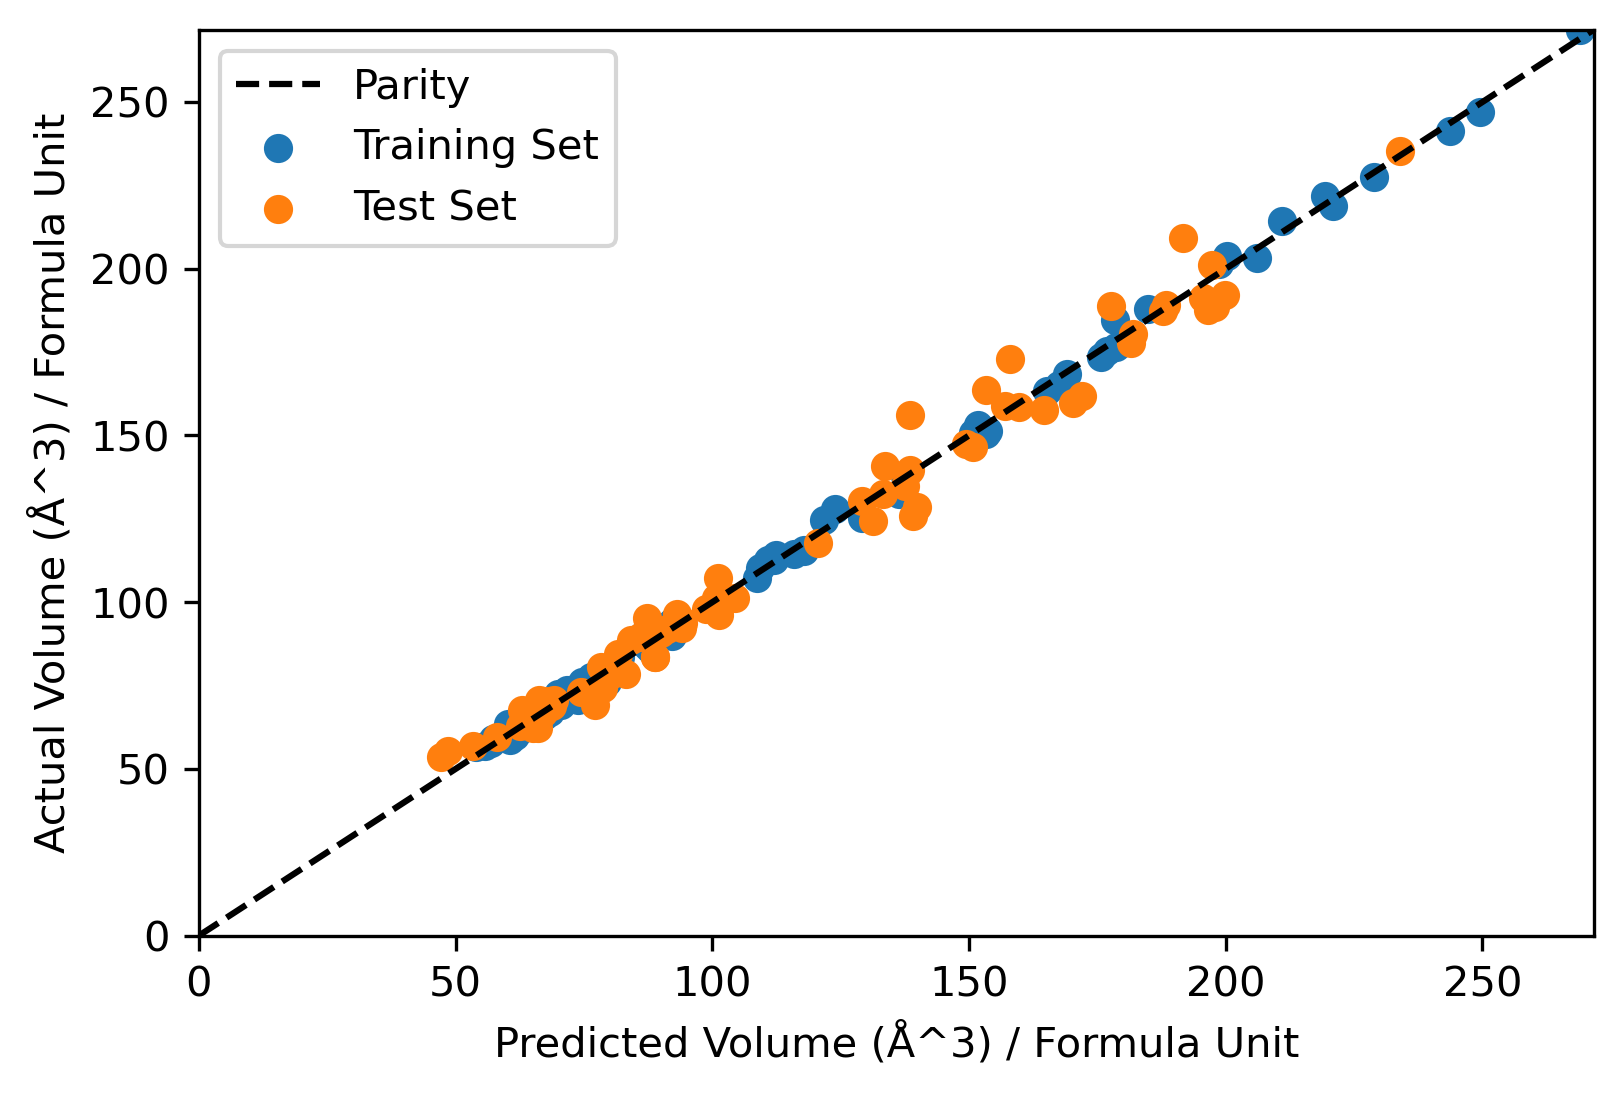

In [18]:
# Print some model statistics
train_preds = model.predict(x)
test_preds = model.predict(test[x_cols].to_numpy())
test_mape = sklearn.metrics.mean_absolute_percentage_error(y_true=test.Volume, y_pred=test_preds)
print(f"Test MAPE = {test_mape}")

# Parity Plot
plt.scatter(train_preds, y, label="Training Set")
plt.scatter(test_preds, test.Volume, label="Test Set")

# Ensure plot is square
lims = [0,
        max(max(y), max(test.Volume.to_numpy()))]
plt.xlim(lims)
plt.ylim(lims)

# Parity Line
plt.plot([lims[0], lims[1]], [lims[0], lims[1]],
         c="black", linestyle="dashed", label="Parity")

# Misc Drawing
plt.legend()
plt.xlabel("Predicted Volume (Å^3) / Formula Unit")
plt.ylabel("Actual Volume (Å^3) / Formula Unit")
plt.show() #Make these larger

# Make a Prediction!

Generally, we train models to do predictions later. To test this out, we'll investigate Samarium Nickle Oxide. According to Materials Project ( https://materialsproject.org/materials/mp-22495/# ), this material has a volume of 226.362 Å^3. Normalized by the number of formula units, the volume is 60.105 Å^3 per formula unit.

We find that our volume is predicted to be 59.59 Å^3 per formula unit.

In [17]:
comp = {
    "Sm": 4,
    "Ni": 4,
    "O": 12,
}

generated_features = element_cal.transform([comp])

# Print the predicted volume
predicted_volume = model.predict(generated_features.to_numpy())[0]
known_volume = 226.362
known_volume_scaled = 5 * known_volume / (4 + 4 + 12)
print(f"Predicted Volume is: {round(predicted_volume,3)} Å^3 / formula unit")
print(f"Known Volume is {round(known_volume_scaled,3)} Å^3 / formula unit")

# Print the features we generated  
generated_features.to_csv("for_prediction_on_cluster.csv")
generated_features

Predicted Volume is: 60.105 Å^3 / formula unit
Known Volume is 56.59 Å^3 / formula unit


,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,22.8,148.720852,202.4,13.7,51.41008,1067.914,89.263625,714.62,104.0,94.2,...,2.0,2.0,0.18,0.02658,152.0,150.0,182.0,283.4,317.5,0.802
